In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

In [3]:
def time_filter(time, start, stop, strength):
    
    
    
    return sf.expit( strength*(time-start)  ) * (1 -sf.expit( strength*(time- stop)  ) )
    

<IPython.core.display.Javascript object>


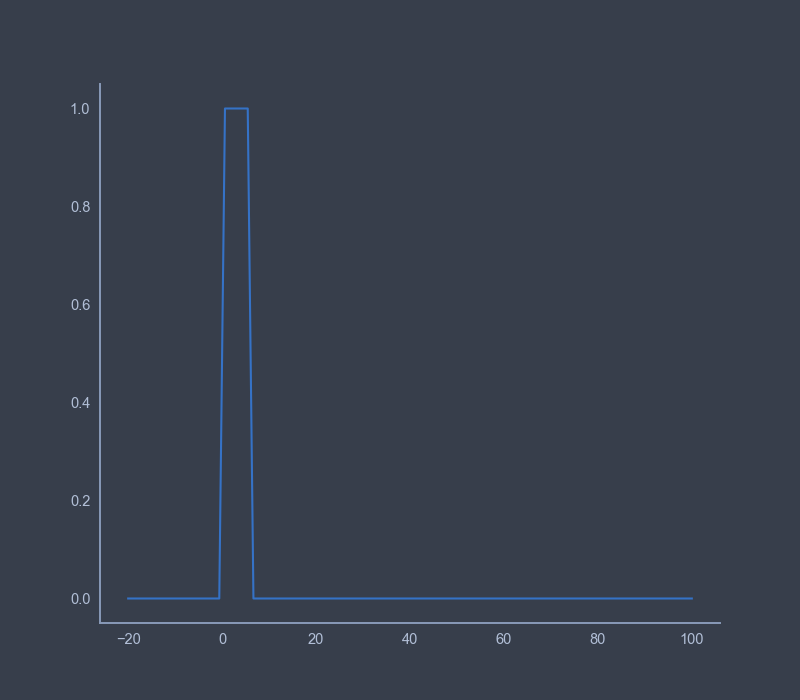

In [4]:
fig, ax = plt.subplots()


xx = np.linspace(-20,100,100)



y = time_filter(xx, 0, 6, 100)


ax.plot(xx, y)


In [2]:
#copy_template()

<IPython.core.display.Javascript object>


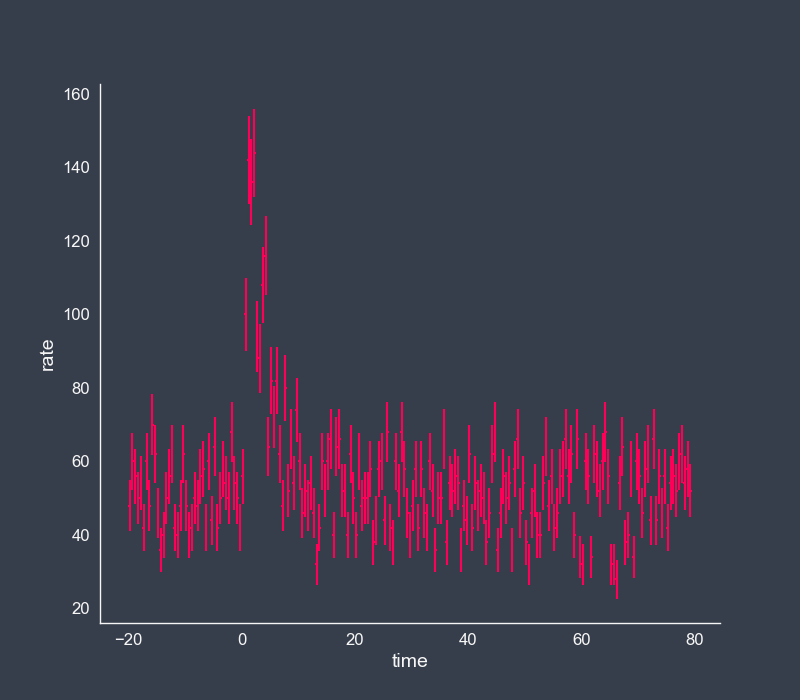

<IPython.core.display.Javascript object>


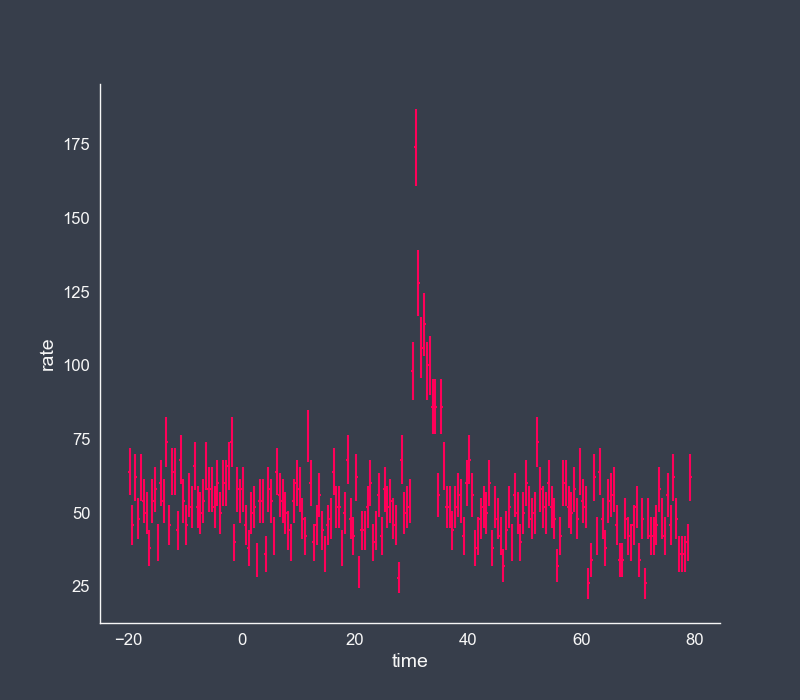

In [24]:
with plt.style.context('mike_dark'):

    uni = Universe.from_yaml('template_config.yaml')
    uni.explode_grb(tstart=-50,tstop=100)
    for det, lc in uni.light_curves.items():

        lc.display(-20,80,.5,color=red)



In [6]:
uni._time_differences

0.
29.64412906


In [26]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-19.4,40.4,1.)
mid = np.mean([times[:-1],times[1:]], axis=0)

lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,80,1)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
k=50

N_model = 200

predict_time = np.linspace(-20,80,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            bw=.2,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time
           
           
           
           )

In [6]:
model = stan_utility.compile_model('rff.stan', model_name='rff')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_974a8b57851a1c9ef5c0049399deae8e NOW.


In [27]:
fit = model.sampling(warmup=2000,iter=2500,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=12, adapt_delta=.9)
                    

                    )

<IPython.core.display.Javascript object>


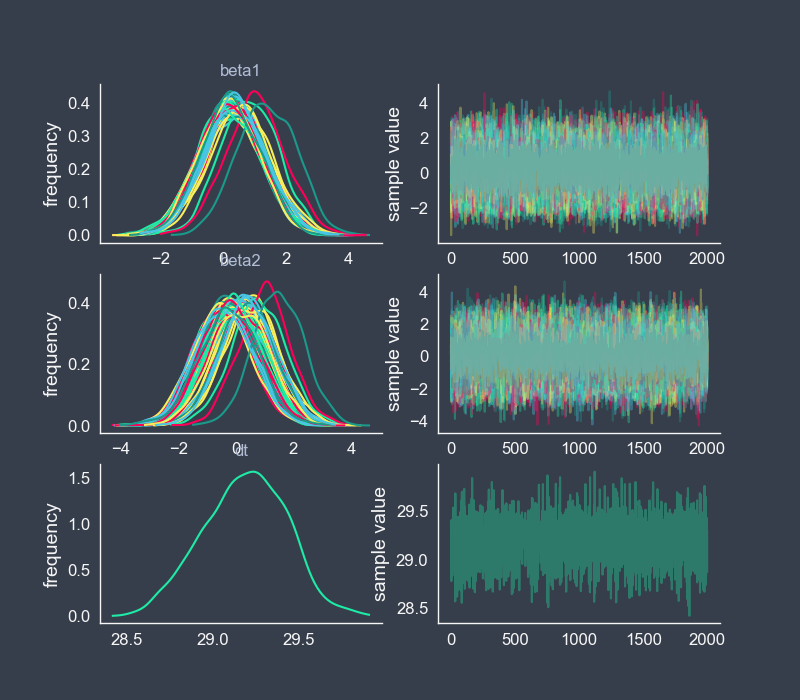

In [28]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt'
             
             ]);

<IPython.core.display.Javascript object>


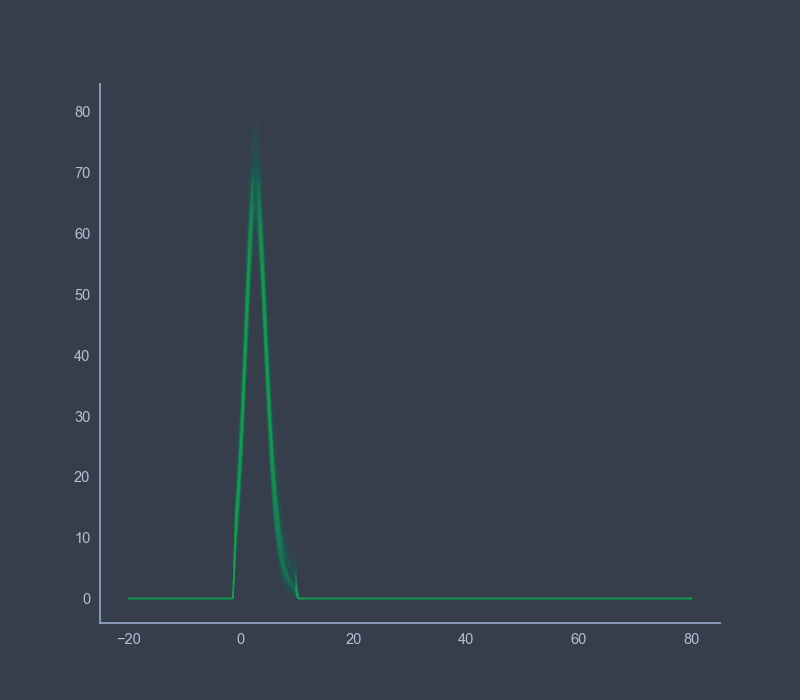

In [29]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::10]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


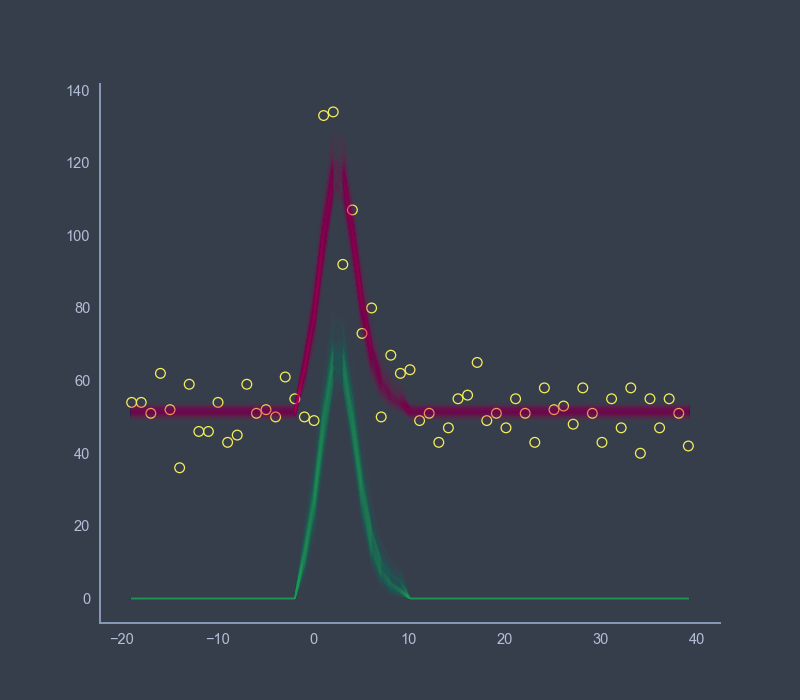

In [30]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, y + b, alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


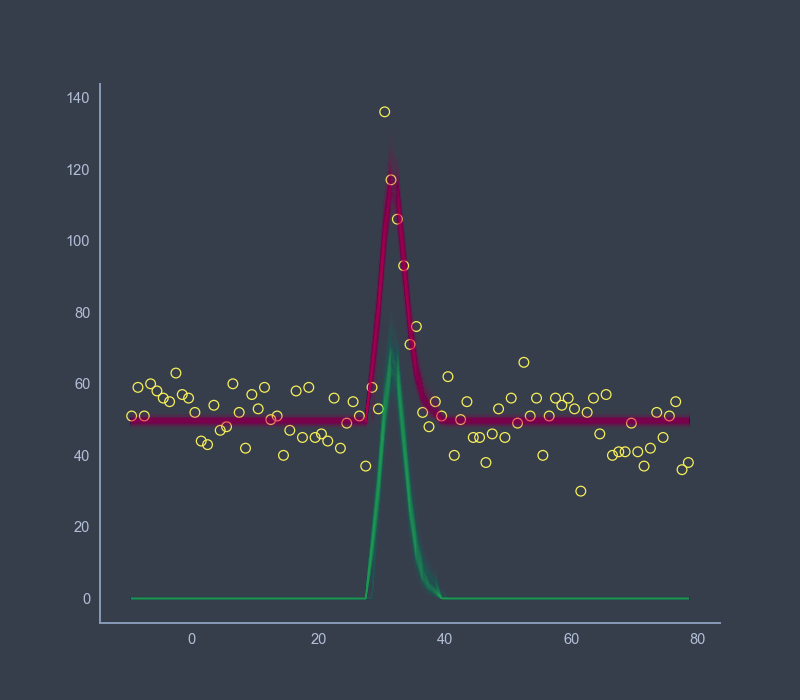

In [31]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


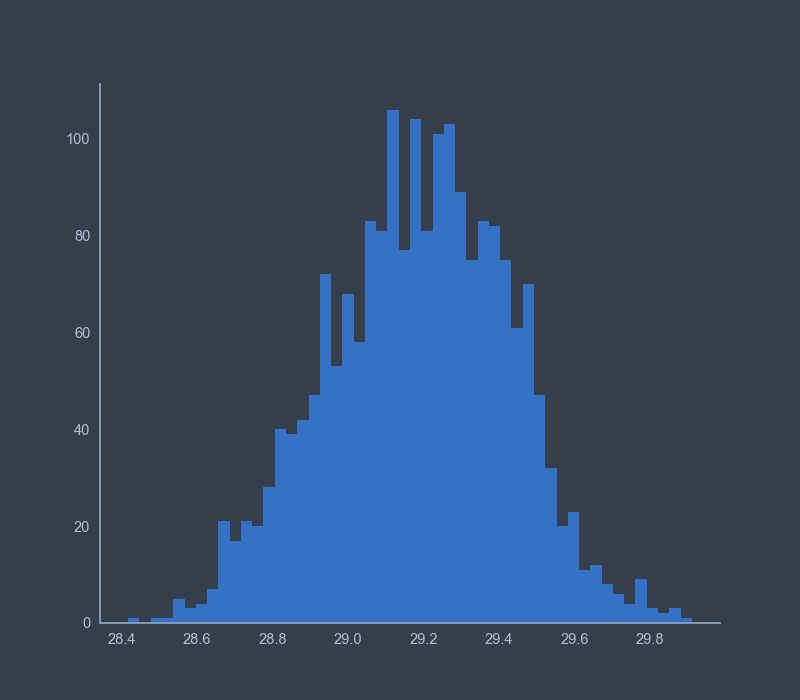

(array([  1.,   0.,   1.,   1.,   5.,   3.,   4.,   7.,  21.,  17.,  21.,
         20.,  28.,  40.,  39.,  42.,  47.,  72.,  53.,  68.,  58.,  83.,
         81., 106.,  77., 104.,  81., 101., 103.,  89.,  75.,  83.,  82.,
         75.,  61.,  70.,  47.,  32.,  20.,  23.,  11.,  12.,   8.,   6.,
          4.,   9.,   3.,   2.,   3.,   1.]),
 array([28.41704939, 28.44692986, 28.47681033, 28.5066908 , 28.53657127,
        28.56645174, 28.59633221, 28.62621268, 28.65609315, 28.68597362,
        28.71585409, 28.74573456, 28.77561503, 28.80549549, 28.83537596,
        28.86525643, 28.8951369 , 28.92501737, 28.95489784, 28.98477831,
        29.01465878, 29.04453925, 29.07441972, 29.10430019, 29.13418066,
        29.16406113, 29.1939416 , 29.22382207, 29.25370254, 29.283583  ,
        29.31346347, 29.34334394, 29.37322441, 29.40310488, 29.43298535,
        29.46286582, 29.49274629, 29.52262676, 29.55250723, 29.5823877 ,
        29.61226817, 29.64214864, 29.67202911, 29.70190958, 29.73179005,
 

In [32]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


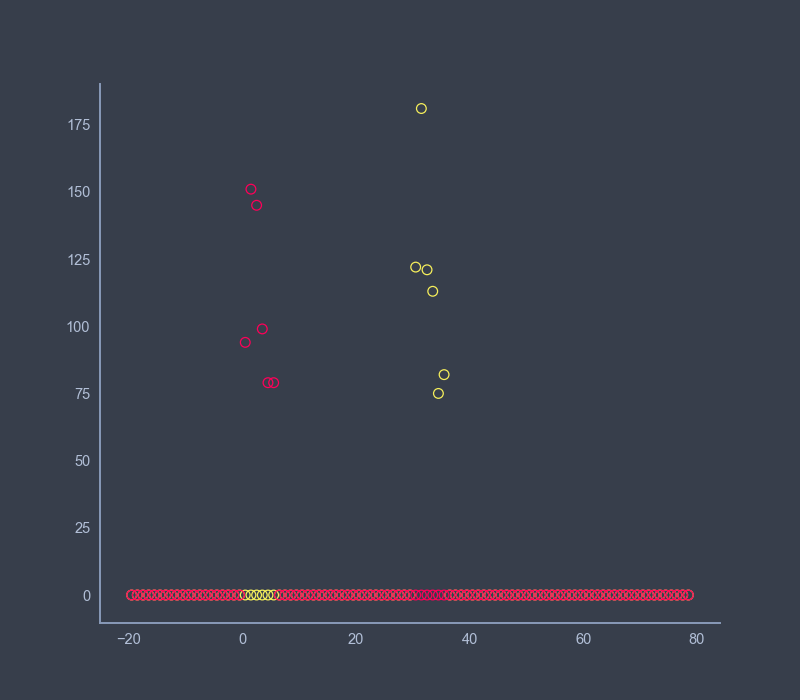

In [143]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2, counts2 * time_filter(mid2 -dt, 0, 6, 100), edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts * time_filter(mid, 0, 6, 100), edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


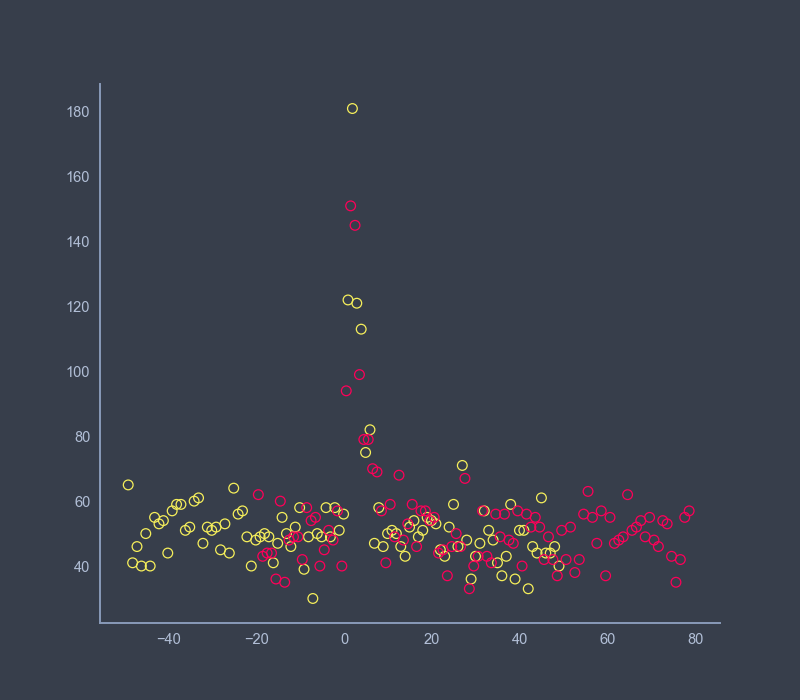

In [145]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2 -dt, counts2 , edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts , edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


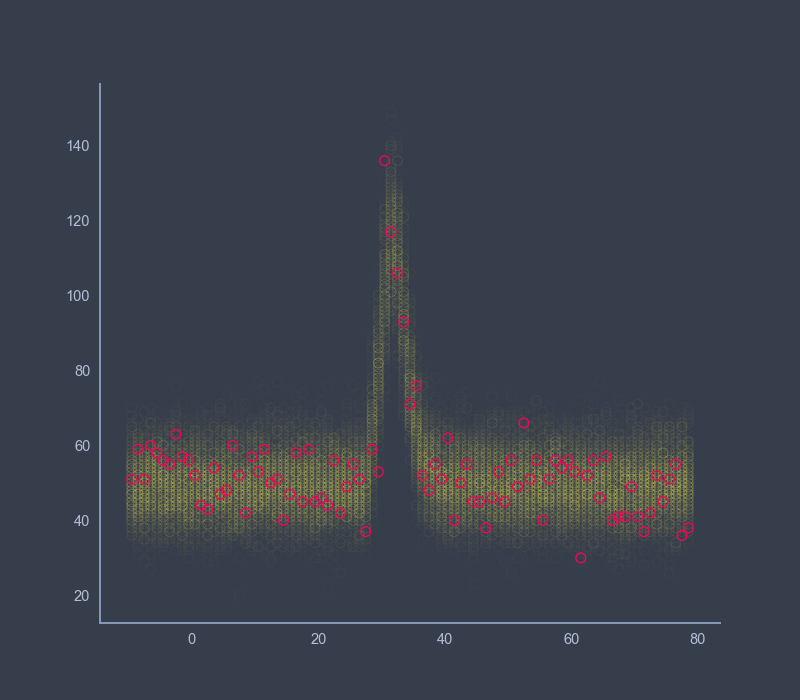

In [33]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


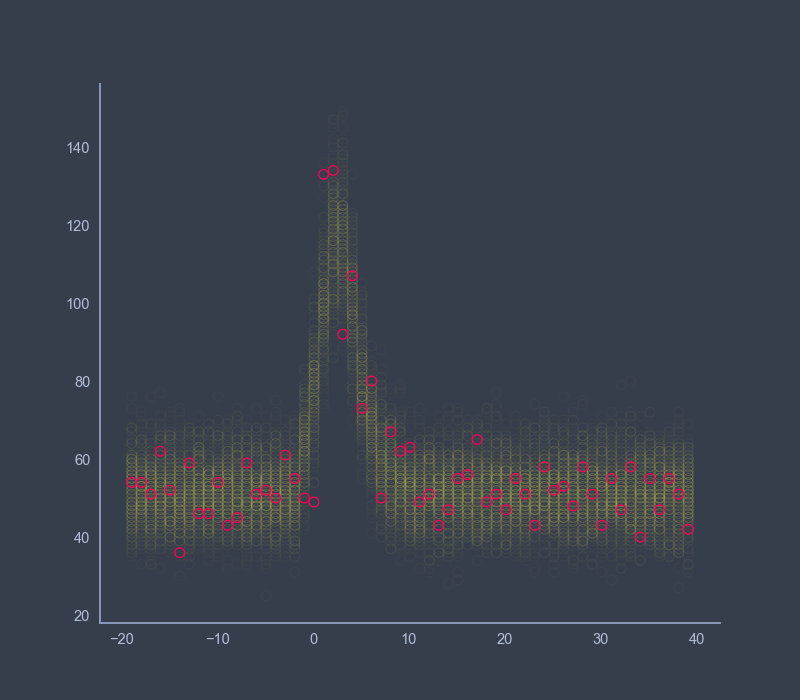

In [34]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)